# BIBLIOTECAS

In [2]:
!pip3 install pandas numpy seaborn matplotlib missingno folium

In [3]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import missingno as msno
import folium

# SANITY CHECK

### Objetivos:

- Entendimento inicial de cada uma das bases de dados
- Analisar propriedades das colunas das bases
- Identificar e tratar possíveis inconsistências nos dados

In [41]:
# Obter a lista de arquivos CSV no diretório
csv_files = glob.glob('../data/raw/*.csv')

df_list = [pd.read_csv(file) for file in csv_files]

In [42]:
csv_files

['../data/raw\\DemographicData_ZCTAs.csv',
 '../data/raw\\df_geocode (1).csv',
 '../data/raw\\EconomicData_ZCTAs (1).csv',
 '../data/raw\\exams_data.csv',
 '../data/raw\\transactional_data (1).csv']

In [43]:
demographic_df = pd.read_csv(csv_files[0])
geocode_df = pd.read_csv(csv_files[1])
economic_df = pd.read_csv(csv_files[2])
exams_df = pd.read_csv(csv_files[3])
transactional_df = pd.read_csv(csv_files[4])

Dataframes criados:
- demographic_df
- geocode_df
- economic_df
- exams_df
- transactional_df

Função para checar duplicadas e valores ausentes nos dataframes

In [44]:
def check_dataframe_quality(df: pd.DataFrame) -> dict:
    """
    Avalia a qualidade de um DataFrame em termos de valores ausentes, duplicados e tipos de dados.

    Args:
        df (pd.DataFrame): DataFrame a ser avaliado.

    Returns:
        dict: Dicionário contendo:
            - 'duplicated_rows' (int): número de linhas duplicadas;
            - 'missing_values' (pd.Series): contagem de valores ausentes por coluna.
    """
    return {
        "duplicated_rows": df.duplicated().sum(),
        "missing_values": df.isnull().sum(),
        "unique_values": df.nunique()
    }

Função para visualização geral dos dados

In [45]:
def summarize_dataframe(df: pd.DataFrame, df_name: str) -> None:
    """
    Exibe informações resumidas de um DataFrame, incluindo colunas, shape e informações gerais.

    Args:
        df (pd.DataFrame): DataFrame a ser resumido.
        df_name (str): Nome do DataFrame.
    """
    print(f"Resumo do DataFrame: {df_name}")
    print("")
    print("Colunas do dataframe:", df.columns)
    print("")
    print("Shape do dataframe:", df.shape)
    print("")
    print(df.info())
    print("")
    pd.set_option('display.width', 1000)
    pd.set_option('display.max_columns', None)
    print(df.head())
    print("")

### Visualização do demographic_df

#### Visão geral do dataframe

In [65]:
summarize_dataframe(demographic_df, "demographic_df")

Resumo do DataFrame: demographic_df

Colunas do dataframe: Index(['Unnamed: 0', 'Id', 'GeographicAreaName', 'TotalPopulation', 'SexRatio(males per 100 females)', 'Population_Under5Years', 'Population_5to9Years', 'Population_10to14Years', 'Population_15to19Years', 'Population_20to24Years', 'Population_25to34Years', 'Population_35to44Years', 'Population_45to54Years', 'Population_55to59Years', 'Population_60to64Years', 'Population_65to74Years', 'Population_75to84Years', 'Population_85YearsAndOver', 'MedianAgeInYears'], dtype='object')

Shape do dataframe: (33120, 19)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33120 entries, 0 to 33119
Data columns (total 19 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       33120 non-null  int64  
 1   Id                               33120 non-null  object 
 2   GeographicAreaName               33120 non-null  object 
 3   Tota

Vamos remover essa primeira coluna que é apenas o index das linhas.

In [66]:
demographic_df = demographic_df.drop(columns=["Unnamed: 0"])

Nota-se que a maioria das colunas da base é numérica, com características relacionadas à demografia populacional da área geográfica. A maior parte das variáveis que descrevem as características populacionais são numéricas, porém existem variáveis aparentemente categóricas, que parecem ser chaves, sendo elas:

- `Id` (Identificador único da área geográfica)
- `GeographicAreaName` (Nome da área geográfica)

In [67]:
print(f"Quantidade de valores únicos na coluna 'Id': {demographic_df['Id'].nunique()}")
print(f"Quantidade de valores únicos na coluna 'GeographicAreaName': {demographic_df['GeographicAreaName'].nunique()}")

Quantidade de valores únicos na coluna 'Id': 33120
Quantidade de valores únicos na coluna 'GeographicAreaName': 33120


Como essas variáveis possuem valores únicos por linha, elas podem ser utilizadas como chaves primárias e servir de referência para realizar junções com outras tabelas.

#### Verificando possíveis incosistências

No contexto do dataframe demográfico, valores negativos em colunas numéricas não são esperados. Portanto, vamos realizar uma validação para verificar se algum valor negativo está presente nessas colunas.

In [68]:
numeric_columns = demographic_df.select_dtypes(include=['int64', 'float64']).columns
negative_values = {col: (demographic_df[col] < 0).any() for col in numeric_columns}
negative_columns = [col for col, has_negative in negative_values.items() if has_negative]
print(f"Colunas com valores negativos: {negative_columns}")

Colunas com valores negativos: []


Nenhuma inconsistência relacionada a valores negativos foi identificada nas colunas numéricas.

#### Verificando e tratando valores ausentes

Vamos iniciar a análise de qualidade verificando valores ausentes, duplicações e a quantidade de valores únicos por coluna.

In [69]:
quality_report = check_dataframe_quality(demographic_df)

print("\nValores ausentes por coluna:\n", quality_report["missing_values"])
print("\nNúmero de linhas duplicadas:", quality_report["duplicated_rows"])
print("\nNúmero de valores únicos por coluna:\n", quality_report["unique_values"])


Valores ausentes por coluna:
 Id                                   0
GeographicAreaName                   0
TotalPopulation                      0
SexRatio(males per 100 females)    500
Population_Under5Years               0
Population_5to9Years                 0
Population_10to14Years               0
Population_15to19Years               0
Population_20to24Years               0
Population_25to34Years               0
Population_35to44Years               0
Population_45to54Years               0
Population_55to59Years               0
Population_60to64Years               0
Population_65to74Years               0
Population_75to84Years               0
Population_85YearsAndOver            0
MedianAgeInYears                   569
dtype: int64

Número de linhas duplicadas: 0

Número de valores únicos por coluna:
 Id                                 33120
GeographicAreaName                 33120
TotalPopulation                    15504
SexRatio(males per 100 females)     1985
Population_Under5Ye

Separando o dataframe em que existem valores nulos para analisarmos melhor.

In [70]:
missing_rows = demographic_df[demographic_df.isnull().any(axis=1)]
print(missing_rows.head())

                 Id GeographicAreaName  TotalPopulation  SexRatio(males per 100 females)  Population_Under5Years  Population_5to9Years  Population_10to14Years  Population_15to19Years  Population_20to24Years  Population_25to34Years  Population_35to44Years  Population_45to54Years  Population_55to59Years  Population_60to64Years  Population_65to74Years  Population_75to84Years  Population_85YearsAndOver  MedianAgeInYears
5    8600000US35013        ZCTA5 35013               46                              NaN                       0                     0                       0                       0                       0                       0                      15                      31                       0                       0                       0                       0                          0              47.9
42   8600000US35074        ZCTA5 35074               99                             86.8                       0                     0                       0  

Aqui aparece algumas informações úteis, algumas dessas colunas em que `SexRatio(males per 100 females)` e `MedianAgeInYears` estão com valores ausentes, a população total da ZCTA é zero. Inicialmente cabe verificarmos essas colunas e tratar as outras que sobrarem.

1. Verificação: ZCTAs com `TotalPopulation` = 0 e se `SexRatio(males per 100 females)` e `MedianAgeInYears` são NaN

In [71]:
pop_zero = missing_rows["TotalPopulation"] == 0

medianage_nan_when_pop_zero = missing_rows.loc[pop_zero, "MedianAgeInYears"].isnull()
sexratio_nan_when_pop_zero = missing_rows.loc[pop_zero, "SexRatio(males per 100 females)"].isnull()
both_nan_when_pop_zero = medianage_nan_when_pop_zero & sexratio_nan_when_pop_zero

print(medianage_nan_when_pop_zero.sum())
print(sexratio_nan_when_pop_zero.sum())
print(both_nan_when_pop_zero.sum())

344
344
344


Todas as ZCTAs com TotalPopulation igual a zero possuem MedianAgeInYears e SexRatio ausentes, como era esperado.

2. Filtrando os casos em que MedianAgeInYears é NaN e TotalPopulation não é zero

In [72]:
filtered_df = missing_rows[~pop_zero & missing_rows["MedianAgeInYears"].isnull()]

print(filtered_df.shape)
print(filtered_df.head())

(225, 18)
                 Id GeographicAreaName  TotalPopulation  SexRatio(males per 100 females)  Population_Under5Years  Population_5to9Years  Population_10to14Years  Population_15to19Years  Population_20to24Years  Population_25to34Years  Population_35to44Years  Population_45to54Years  Population_55to59Years  Population_60to64Years  Population_65to74Years  Population_75to84Years  Population_85YearsAndOver  MedianAgeInYears
42   8600000US35074        ZCTA5 35074               99                             86.8                       0                     0                       0                       0                       0                      99                       0                       0                       0                       0                       0                       0                          0               NaN
97   8600000US35187        ZCTA5 35187                6                            100.0                       0                     0                

Em seguida, verificamos se existe alguma informação populacional por faixa etária nos casos filtrados, mesmo com a ausência de `MedianAgeInYears`.

In [73]:
age_columns = [col for col in missing_rows.columns if "Population_" in col and "Years" in col]

In [74]:
has_population_values = (filtered_df[age_columns] > 0).any(axis=1).any()

if has_population_values:
    print("O DataFrame filtrado possui pelo menos uma coluna com valor maior que zero.")
else:
    print("O DataFrame filtrado não contém nenhuma coluna com valores populacionais maiores que zero.")

O DataFrame filtrado possui pelo menos uma coluna com valor maior que zero.


Dos 569 valores ausentes em `MedianAgeInYears`, observamos o seguinte cenário:

- **344** ocorrem em ZCTAs com `TotalPopulation` igual a zero, o que justifica a ausência do dado;
- **225** correspondem a ZCTAs com população total maior que zero. Nesses casos, embora o valor da mediana possa ser estimado a partir da distribuição populacional por faixa etária, ele não foi informado, o que pode indicar uma lacuna ou falha na consolidação dos dados.

3. Calculando `MedianAgeInYears` nos casos em que conseguimos calcular.

A seguir, definimos uma função para estimar a idade mediana (`MedianAgeInYears`) com base na distribuição de população por faixas etárias. A estimativa utiliza o conceito de mediana em classes, considerando os limites e larguras das faixas etárias disponíveis.

In [75]:
age_classes = {
    "Population_Under5Years": (0, 5),
    "Population_5to9Years": (5, 5),
    "Population_10to14Years": (10, 5),
    "Population_15to19Years": (15, 5),
    "Population_20to24Years": (20, 5),
    "Population_25to34Years": (25, 10),
    "Population_35to44Years": (35, 10),
    "Population_45to54Years": (45, 10),
    "Population_55to59Years": (55, 5),
    "Population_60to64Years": (60, 5),
    "Population_65to74Years": (65, 10),
    "Population_75to84Years": (75, 10),
    "Population_85YearsAndOver": (85, 15)  # estimativa para o final aberto
}

def estimate_median_class(row):
    """
    Estima a mediana usando distribuição em classes para faixas etárias.
    
    Args:
        row (pd.Series): Linha com dados de população por faixa etária.
    
    Returns:
        float: Idade mediana estimada ou None.
    """
    frequencies = [(col, row[col]) for col in age_columns if pd.notnull(row[col]) and row[col] > 0]
    total_pop = sum(freq for _, freq in frequencies)

    if total_pop == 0:
        return None

    cumulative = 0
    for col, freq in frequencies:
        cumulative += freq
        if cumulative >= total_pop / 2:
            L, w = age_classes[col]
            prev_cum = cumulative - freq
            median = L + (((total_pop / 2) - prev_cum) / freq) * w
            return median

    return None

def should_apply_median(row):
    pop_sum = row[age_columns].sum()
    return pop_sum == row["TotalPopulation"]

Para os casos em que há população total e as faixas etárias estão devidamente preenchidas, conseguimos calcular `MedianAgeInYears` por meio da função de estimativa definida.

In [76]:
filtered_df.loc[filtered_df.apply(should_apply_median, axis=1), "MedianAgeInYears"] = filtered_df[filtered_df.apply(should_apply_median, axis=1)].apply(estimate_median_class, axis=1)

filtered_df.head()

,Id,GeographicAreaName,TotalPopulation,SexRatio(males per 100 females),Population_Under5Years,Population_5to9Years,Population_10to14Years,Population_15to19Years,Population_20to24Years,Population_25to34Years,Population_35to44Years,Population_45to54Years,Population_55to59Years,Population_60to64Years,Population_65to74Years,Population_75to84Years,Population_85YearsAndOver,MedianAgeInYears
42,8600000US35074,ZCTA5 35074,99,86.8,0,0,0,0,0,99,0,0,0,0,0,0,0,30.000000
97,8600000US35187,ZCTA5 35187,6,100.0,0,0,0,0,0,0,0,0,0,0,6,0,0,70.000000
178,8600000US35559,ZCTA5 35559,12,100.0,0,0,0,0,0,0,6,6,0,0,0,0,0,45.000000
207,8600000US35615,ZCTA5 35615,60,252.9,0,0,0,0,0,0,43,0,17,0,0,0,0,41.976744
403,8600000US36267,ZCTA5 36267,7,NaN,0,0,0,0,0,0,0,0,7,0,0,0,0,57.500000


Vamos manter o `filtered_df` com os valores estimados em espera. Caso, ao final desta etapa da análise, consideremos adequado, poderemos substituir essas linhas diretamente no dataframe demográfico original.

4. Filtrando os casos em que `SexRatio(males per 100 females)` é NaN e TotalPopulation não é zero

Selecionamos as linhas em que a razão de sexo está ausente, mesmo havendo população registrada — o que pode indicar uma falha na coleta ou no processamento desses dados.

In [77]:
filtered_sexratio_nan = demographic_df[(demographic_df["TotalPopulation"] != 0) & (demographic_df["SexRatio(males per 100 females)"].isnull())]

print(filtered_sexratio_nan)

                   Id GeographicAreaName  TotalPopulation  SexRatio(males per 100 females)  Population_Under5Years  Population_5to9Years  Population_10to14Years  Population_15to19Years  Population_20to24Years  Population_25to34Years  Population_35to44Years  Population_45to54Years  Population_55to59Years  Population_60to64Years  Population_65to74Years  Population_75to84Years  Population_85YearsAndOver  MedianAgeInYears
5      8600000US35013        ZCTA5 35013               46                              NaN                       0                     0                       0                       0                       0                       0                      15                      31                       0                       0                       0                       0                          0              47.9
403    8600000US36267        ZCTA5 36267                7                              NaN                       0                     0                    

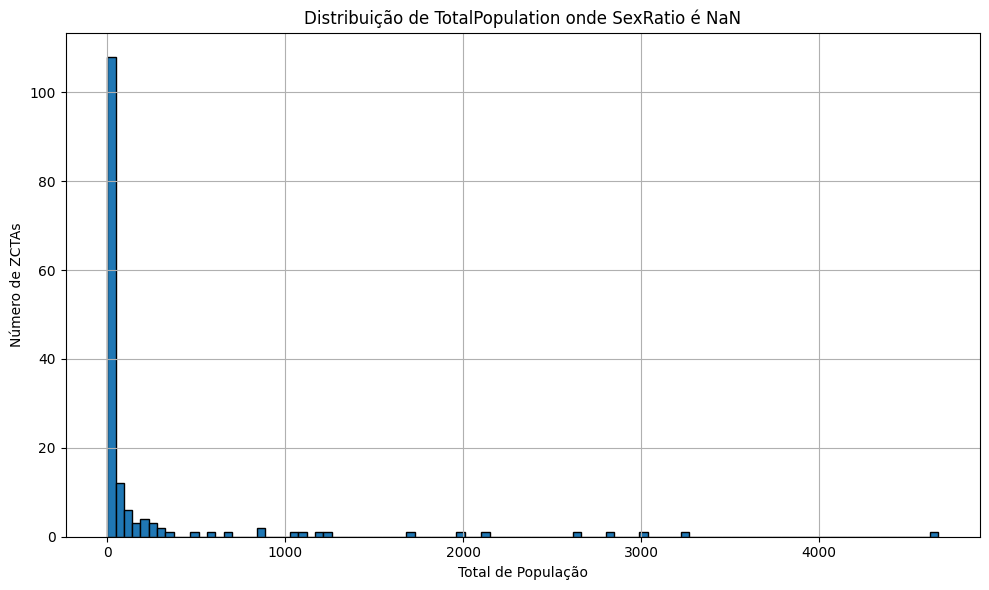

In [78]:
plt.figure(figsize=(10, 6))
plt.hist(filtered_sexratio_nan["TotalPopulation"], bins=100, edgecolor='black')
plt.title("Distribuição de TotalPopulation onde SexRatio é NaN")
plt.xlabel("Total de População")
plt.ylabel("Número de ZCTAs")
plt.grid(True)
plt.tight_layout()
plt.show()

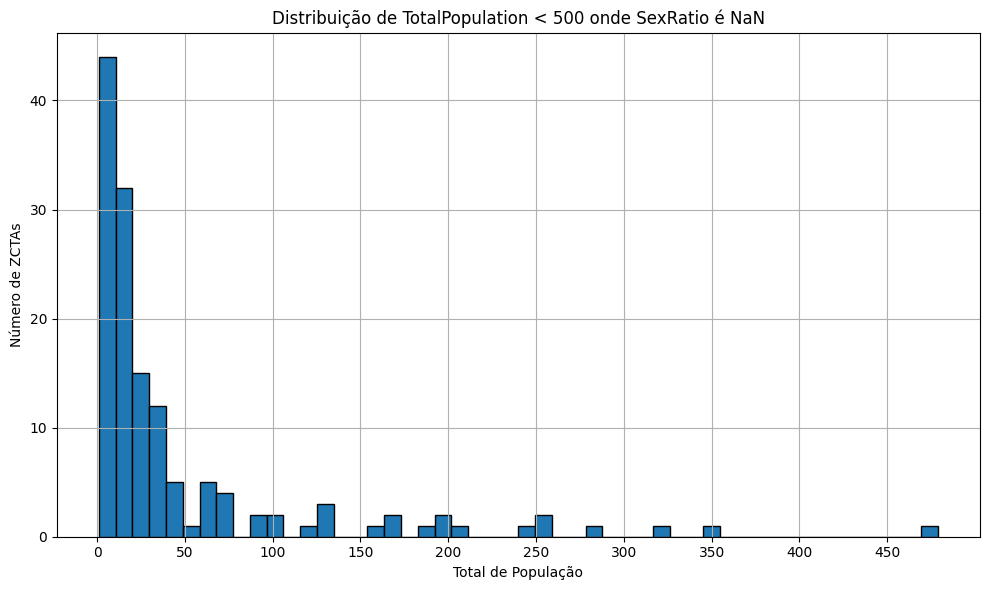

In [79]:
filtered_population = filtered_sexratio_nan[filtered_sexratio_nan["TotalPopulation"] < 500]

plt.figure(figsize=(10, 6))
plt.hist(filtered_population["TotalPopulation"], bins=50, edgecolor='black')
plt.title("Distribuição de TotalPopulation < 500 onde SexRatio é NaN")
plt.xlabel("Total de População")
plt.ylabel("Número de ZCTAs")
plt.grid(True)
plt.xticks(np.arange(0, 500, 50))  # Adiciona mais marcações no eixo x
plt.tight_layout()
plt.show()

Filtramos os casos com população total nas faixas etárias igual ou inferior a 30 indivíduos.

In [80]:
population_sum = filtered_sexratio_nan[age_columns].sum(axis=1)
rows_with_population_leq_30 = filtered_sexratio_nan[population_sum <= 30]
print(len(rows_with_population_leq_30))

92


Com base nos dois histogramas, observamos uma concentração significativa de casos com `SexRatio` ausente (`NaN`) em regiões com população total bastante reduzida. Essa ausência pode ser explicada pela presença de indivíduos de apenas um dos gêneros nesses ZCTAs, o que inviabiliza o cálculo da razão entre homens e mulheres. Aproximadamente **60%** dos registros com `SexRatio` ausente possuem uma população total igual ou inferior a 30 indivíduos.

Por outro lado, também identificamos alguns casos com população relativamente alta e `SexRatio` ausente. Esses casos podem indicar regiões com restrições de sexo — como áreas ocupadas predominantemente por homens ou mulheres — a exemplo de instalações militares, monastérios ou outras zonas com acesso restrito por gênero. Esse é um ponto que vale ser analisando cerificando as localizações geográficas.

Substituímos os valores originais pela mediana recalculada a partir de `filtered_df`, por ser uma medida mais robusta. A atualização foi feita com base na correspondência entre os IDs.

In [81]:
demographic_df.update(filtered_df[['Id', 'MedianAgeInYears']].set_index('Id'))
demographic_df.reset_index(inplace=True)

#### Verificando os outliers

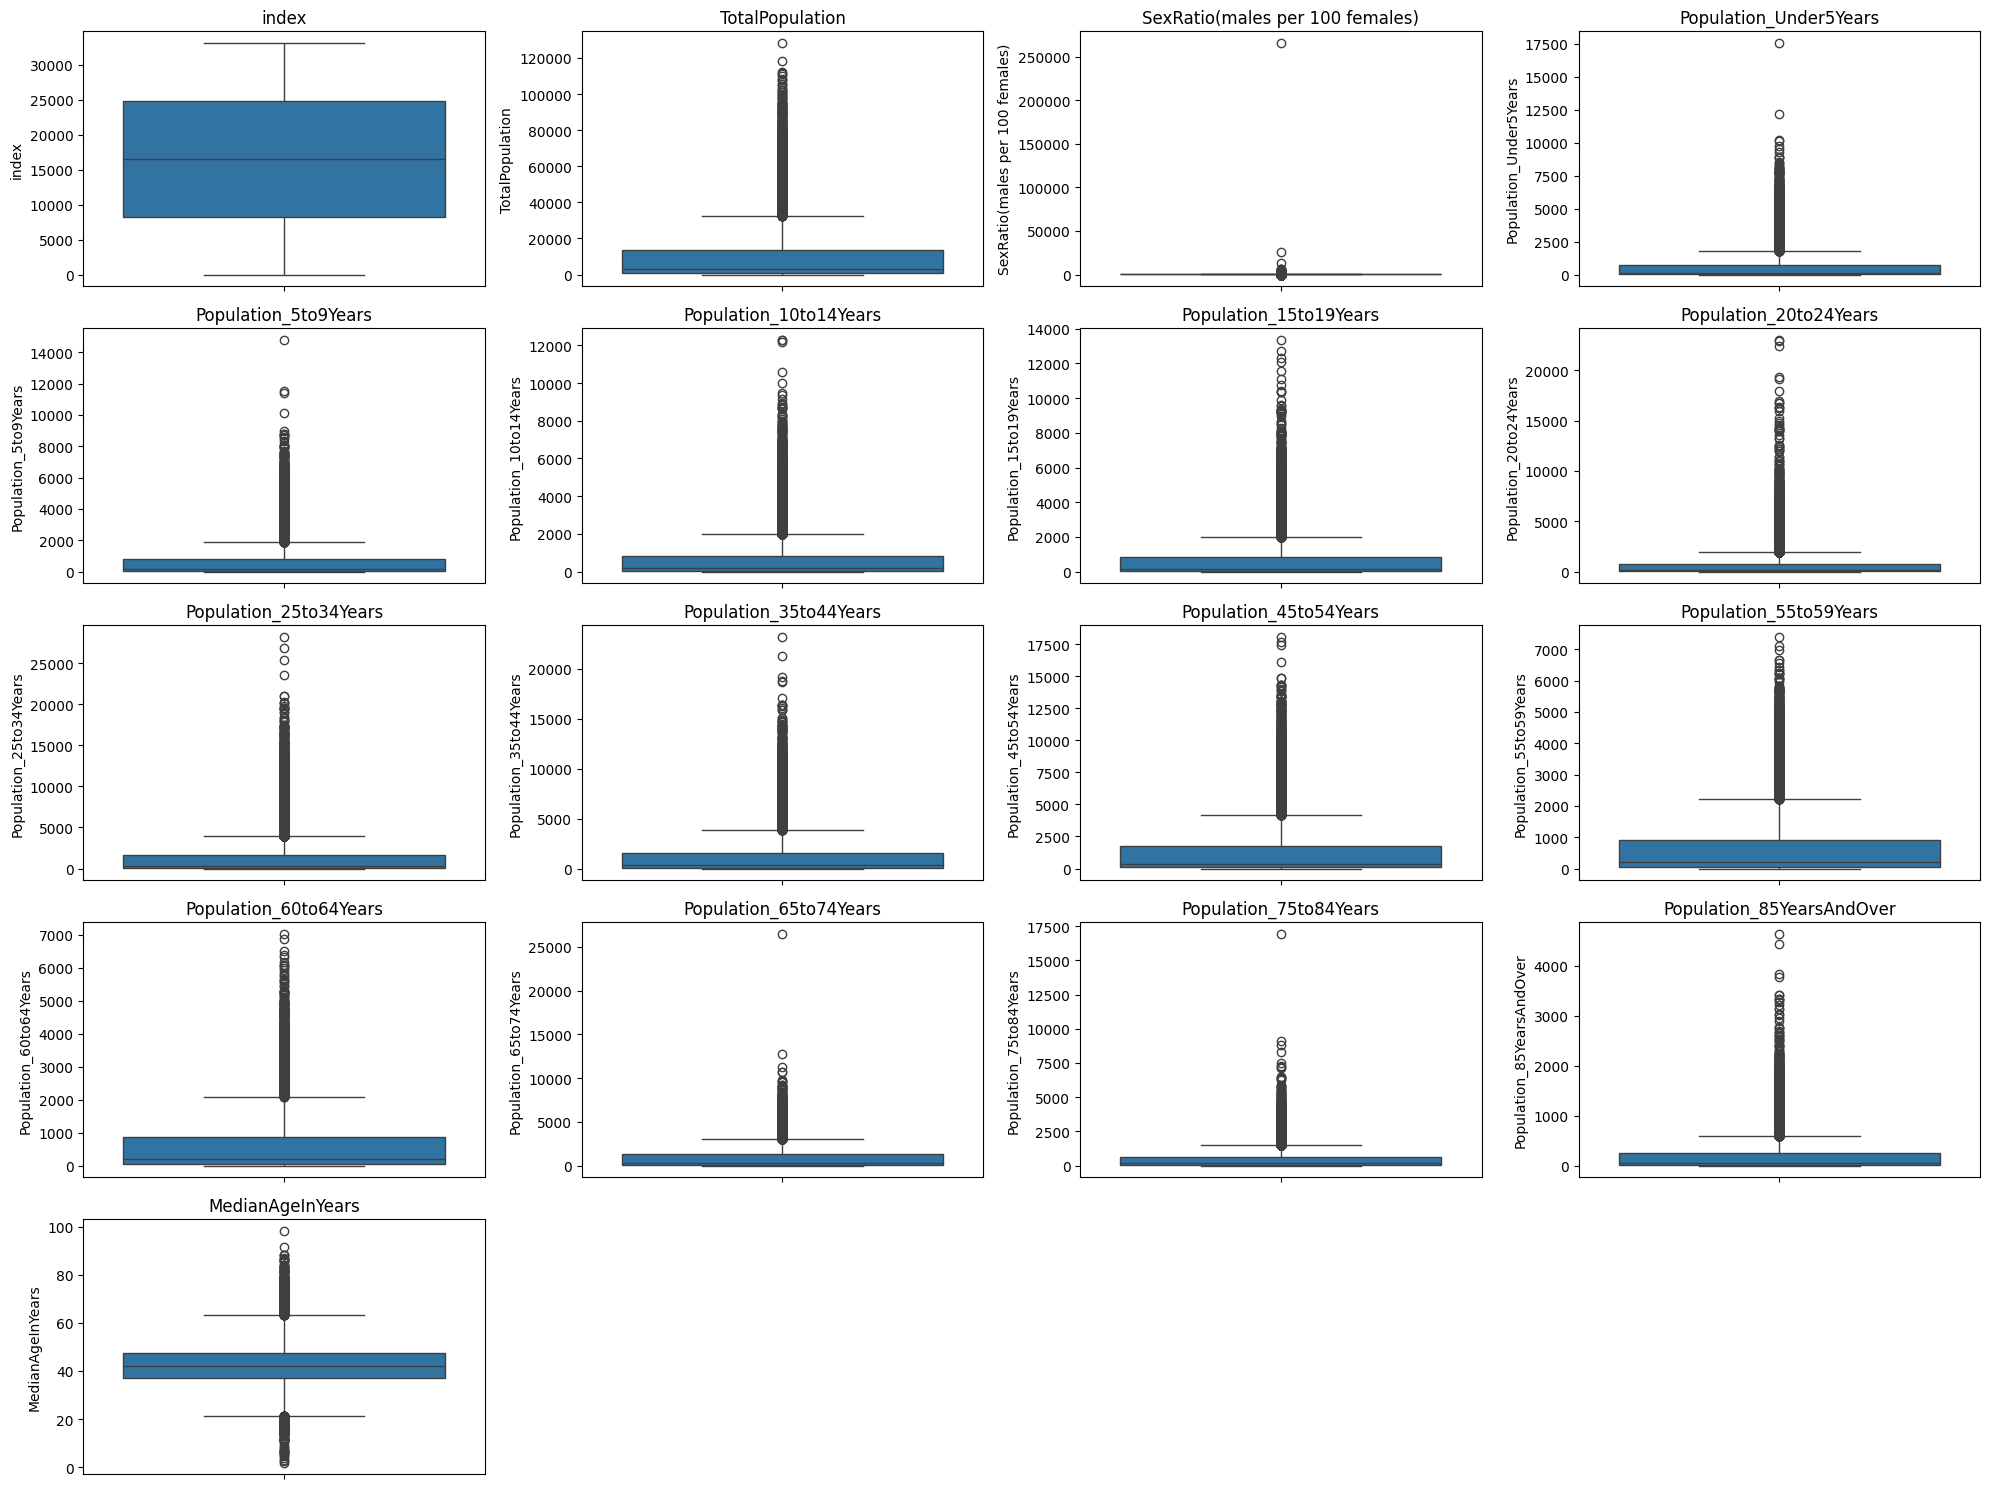

In [82]:
plt.figure(figsize=(20, 15))

for i, column in enumerate(demographic_df.select_dtypes(include=['int64', 'float64']).columns, 1):
    plt.subplot(5, 4, i)
    sns.boxplot(y=demographic_df[column])
    plt.title(column)

plt.tight_layout()
plt.show()

Conclusão e Recomendações

Os dados demográficos refletem bem a diversidade entre os ZCTAs, com assimetria à direita e outliers esperados em regiões mais populosas. Esses valores não devem ser descartados, pois podem indicar oportunidades relevantes. Para análises futuras, recomenda-se o uso de medidas robustas (como a mediana) e, se necessário, transformações logarítmicas para reduzir o impacto de extremos. Em modelagens, algoritmos como árvores de decisão e gradient boosting são mais apropriados por lidarem bem com distribuições não normais.

### Visualização do geocode_df

#### Visão geral do dataframe

In [83]:
summarize_dataframe(geocode_df, "geocode_df")

Resumo do DataFrame: geocode_df

Colunas do dataframe: Index(['Unnamed: 0', 'Lab Id', 'Address', 'Location', 'Zipcode'], dtype='object')

Shape do dataframe: (119, 5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  119 non-null    int64  
 1   Lab Id      119 non-null    object 
 2   Address     119 non-null    object 
 3   Location    119 non-null    object 
 4   Zipcode     118 non-null    float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.8+ KB
None

   Unnamed: 0 Lab Id                                            Address                 Location  Zipcode
0           0   L152      3800 PLEASANT HILL RD STE 1, DULUTH, GA 30096    34.000319,-84.1629724  30096.0
1           1   L520                    1614 N JAMES ST, ROME, NY 13440   43.2311327,-75.4445363  13440.0
2           2   L141     12911 120TH AVE NE STE D60, KI

Vamos remover essa primeira coluna que é apenas o index das linhas.

In [84]:
geocode_df = geocode_df.drop(columns=["Unnamed: 0"])

In [85]:
geocode_df.head()

,Lab Id,Address,Location,Zipcode
0,L152,"3800 PLEASANT HILL RD STE 1, DULUTH, GA 30096","34.000319,-84.1629724",30096.0
1,L520,"1614 N JAMES ST, ROME, NY 13440","43.2311327,-75.4445363",13440.0
2,L141,"12911 120TH AVE NE STE D60, KIRKLAND, WA 98034","47.7162786,-122.1838152",98034.0
3,L524,"5667 PEACHTREE DUNWOODY RD 250, ATLANTA, GA 30342","33.9093875,-84.3529096",30342.0
4,L545,"1204 IL HWY 164, OQUAWKA, IL 61469","40.9309925,-90.9437598",61469.0


Descrição das colunas

- **Lab Id** (`object`): Identificador único do laboratório. Atua como chave primária dessa tabela e sera usado como chave estrangeira em outras bases, como `transactional_data`.

- **Address** (`object`): Endereço completo do laboratório, armazenado como string. Útil para inspeção manual e validações pontuais.

- **Location** (`object`): Coordenadas geográficas no formato "latitude, longitude". Essencial para análises espaciais, como mapeamento e clusterização. Idealmente deve ser desmembrado em duas colunas numéricas.

- **Zipcode** (`float64`): Código ZCTA (Zip Code Tabulation Area) associado ao laboratório. Permite junção com bases externas de dados econômicos e dmográficos.

- **Unnamed: 0** (`int64`): Coluna de índice automático gerada na exportação do dataframe. Não possui valor analítico e pode ser descartada.

Observação sobre a coluna `Location`

A coluna `Location` armazena as coordenadas geográficas no formato "latitude, longitude". Para facilitar análises espaciais e permitir operações com bibliotecas geográficas, pode ser interessante dividir essa coluna em duas novas colunas: `Latitude` e `Longitude`.

#### Verificando e tratando valores ausentes

Vamos iniciar a análise de qualidade verificando valores ausentes, duplicações e a quantidade de valores únicos por coluna.

In [86]:
quality_report = check_dataframe_quality(geocode_df)

print("\nValores ausentes por coluna:\n", quality_report["missing_values"])
print("\nNúmero de linhas duplicadas:", quality_report["duplicated_rows"])
print("\nNúmero de valores únicos por coluna:\n", quality_report["unique_values"])


Valores ausentes por coluna:
 Lab Id      0
Address     0
Location    0
Zipcode     1
dtype: int64

Número de linhas duplicadas: 0

Número de valores únicos por coluna:
 Lab Id      119
Address     119
Location    117
Zipcode     105
dtype: int64


In [87]:
print(geocode_df[geocode_df['Zipcode'].isnull()])

   Lab Id      Address     Location  Zipcode
83     -2  Unavailable  Unavailable      NaN


In [88]:
unavailable_rows = geocode_df[geocode_df.isin(["Unavailable"]).any(axis=1)]
print(unavailable_rows)

   Lab Id      Address     Location  Zipcode
83     -2  Unavailable  Unavailable      NaN


In [89]:
print(f"Quantidade de linhas com 'Lab Id' igual a '-2': {geocode_df[geocode_df['Lab Id'] == '-2'].shape[0]}")

Quantidade de linhas com 'Lab Id' igual a '-2': 1


Registro inválido identificado

Foi encontrado um único registro com `Zipcode` ausente. Este registro possui também:

- `Lab Id` inválido (`-2`)
- `Address` e `Location` marcados como "Unavailable"

Trata-se de uma entrada inválida, provavelmente originada por erro de integração ou preenchimento. O registro será removido para evitar ruído nas análises, pois não contém nenhuma informação geográfica utilizável.

In [90]:
geocode_df = geocode_df[geocode_df["Lab Id"] != "-2"]

In [91]:
print(f"Quantidade de linhas com 'Lab Id' igual a '-2': {geocode_df[geocode_df['Lab Id'] == '-2'].shape[0]}")

Quantidade de linhas com 'Lab Id' igual a '-2': 0


Verificando se existem outras linhas em que o Lab Id (PK da tabela) está com algum id inválido, que não comece com L.

In [62]:
invalid_lab_ids = geocode_df[~geocode_df["Lab Id"].str.startswith("L")]
print(invalid_lab_ids)

Empty DataFrame
Columns: [Lab Id, Address, Location, Zipcode]
Index: []


#### Visualização espacial dos laboratórios

A coluna `Location` foi separada em `Latitude` e `Longitude`, permitindo a plotagem dos laboratórios em um mapa.

In [94]:
geocode_df[['Latitude', 'Longitude']] = geocode_df['Location'].str.split(',', expand=True).astype(float)
geocode_df.head()

,Lab Id,Address,Location,Zipcode,Latitude,Longitude
0,L152,"3800 PLEASANT HILL RD STE 1, DULUTH, GA 30096","34.000319,-84.1629724",30096.0,34.000319,-84.162972
1,L520,"1614 N JAMES ST, ROME, NY 13440","43.2311327,-75.4445363",13440.0,43.231133,-75.444536
2,L141,"12911 120TH AVE NE STE D60, KIRKLAND, WA 98034","47.7162786,-122.1838152",98034.0,47.716279,-122.183815
3,L524,"5667 PEACHTREE DUNWOODY RD 250, ATLANTA, GA 30342","33.9093875,-84.3529096",30342.0,33.909388,-84.352910
4,L545,"1204 IL HWY 164, OQUAWKA, IL 61469","40.9309925,-90.9437598",61469.0,40.930993,-90.943760


In [ ]:
lat_mean = geocode_df['Latitude'].mean()
lon_mean = geocode_df['Longitude'].mean()
mapa = folium.Map(location=[lat_mean, lon_mean], zoom_start=4)

# cria e adiicona os marcadores
for _, row in geocode_df.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"Lab Id: {row['Lab Id']}",
        tooltip=row['Address']
    ).add_to(mapa)

mapa

- Uma na costa leste, especialmente no nordeste dos EUA, com destaque para áreas como Nova York, Pensilvânia, Illinois e Michigan.
- **Presença pontual na costa oeste**, com unidades na Califórnia e Washington.
- Algumas regiões dos EUA, como o sul, sudoeste e grandes áreas do centro-oeste, **ainda não contam com cobertura da rede**, o que pode representar oportunidade para expansão estratégica.

### Visualização do economic_df

#### Visão geral do dataframe

In [46]:
summarize_dataframe(economic_df, "economic_df")

Resumo do DataFrame: economic_df

Colunas do dataframe: Index(['Unnamed: 0', 'id', 'Geographic Area Name', 'TotalHouseholds_LessThan$10.000', 'TotalHouseholds_$10.000to$14.999', 'TotalHouseholds_$15.000to$24.999', 'TotalHouseholds_$25.000to$34.999', 'TotalHouseholds_$35.000to$49.999', 'TotalHouseholds_$50.000to$74.999', 'TotalHouseholds_$75.000to$99.999', 'TotalHouseholds_$100.000to$149.999', 'TotalHouseholds_$150.000to$199.999', 'TotalHouseholds_$200.000OrMore'], dtype='object')

Shape do dataframe: (629280, 13)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629280 entries, 0 to 629279
Data columns (total 13 columns):
 #   Column                              Non-Null Count   Dtype 
---  ------                              --------------   ----- 
 0   Unnamed: 0                          629280 non-null  int64 
 1   id                                  629280 non-null  object
 2   Geographic Area Name                629280 non-null  object
 3   TotalHouseholds_LessThan$10.000     629

Vamos remover essa primeira coluna que é apenas o index das linhas.

In [47]:
economic_df = economic_df.drop(columns=["Unnamed: 0"])

Aparentemente, os 5 dígitos finais da coluna `id` parecem representar o código ZCTA, já que coincidem com o valor informado em `Geographic Area Name`.

In [48]:
aux_df = economic_df[['id', 'Geographic Area Name']].copy()
aux_df['Extracted_ZCTA'] = aux_df['id'].str[-5:]
aux_df['ZCTA_from_Name'] = aux_df['Geographic Area Name'].str.split().str[-1]
aux_df['ZCTA_Match'] = aux_df['Extracted_ZCTA'] == aux_df['ZCTA_from_Name']

if aux_df['ZCTA_Match'].all():
    print("Todas as linhas deram True.")
else:
    print("Existem linhas que não deram True.")


Todas as linhas deram True.


A verificação confirma que os 5 dígitos finais da coluna `id` correspondem exatamente ao código ZCTA presente em `Geographic Area Name`.

Descrições das colunas do df

- `id`: Código único do registro, com o padrão `8600000USXXXXX`, onde `XXXXX` representa o ZCTA (Zip Code Tabulation Area).

- `Geographic Area Name`: Nome da área geográfica correspondente ao ZCTA (exemplo: "ZCTA5 35004").

- `TotalHouseholds (faixas de renda)`: Conjunto de colunas que representam a quantidade de domicílios em diferentes faixas de renda anual dentro de cada ZCTA. As faixas vão desde menos de $10.000 até rendas iguais ou superiores a $200.000.



#### Verificando possíveis incosistências

No contexto do dataframe econômico, que apresenta a quantidade de domicílios por faixa de renda, valores negativos em colunas numéricas não são esperados. Por isso, é importante realizar uma validação para identificar possíveis valores negativos nas colunas de distribuição de domicílios por renda.

In [49]:
household_columns = [col for col in economic_df.columns if "TotalHouseholds" in col]
negative_values = (economic_df[household_columns] < 0).any()
columns_with_negatives = negative_values[negative_values].index.tolist()
columns_with_negatives

[]

Nenhuma inconsistência relacionada a valores negativos foi identificada nas colunas numéricas.

#### Verificando e tratando valores ausentes

Vamos iniciar a análise de qualidade verificando valores ausentes, duplicações e a quantidade de valores únicos por coluna.

In [50]:
quality_report = check_dataframe_quality(economic_df)

print("\nValores ausentes por coluna:\n", quality_report["missing_values"])
print("\nNúmero de linhas duplicadas:", quality_report["duplicated_rows"])
print("\nNúmero de valores únicos por coluna:\n", quality_report["unique_values"])


Valores ausentes por coluna:
 id                                    0
Geographic Area Name                  0
TotalHouseholds_LessThan$10.000       0
TotalHouseholds_$10.000to$14.999      0
TotalHouseholds_$15.000to$24.999      0
TotalHouseholds_$25.000to$34.999      0
TotalHouseholds_$35.000to$49.999      0
TotalHouseholds_$50.000to$74.999      0
TotalHouseholds_$75.000to$99.999      0
TotalHouseholds_$100.000to$149.999    0
TotalHouseholds_$150.000to$199.999    0
TotalHouseholds_$200.000OrMore        0
dtype: int64

Número de linhas duplicadas: 596160

Número de valores únicos por coluna:
 id                                    33120
Geographic Area Name                  33120
TotalHouseholds_LessThan$10.000        1989
TotalHouseholds_$10.000to$14.999       1479
TotalHouseholds_$15.000to$24.999       2387
TotalHouseholds_$25.000to$34.999       2341
TotalHouseholds_$35.000to$49.999       2900
TotalHouseholds_$50.000to$74.999       3697
TotalHouseholds_$75.000to$99.999       2963
Tota

O dataframe apresenta muitas linhas duplicadas. Vamos explorar melhor para entender se são duplicatas exatas ou se há variações sutis entre elas.

In [51]:
duplicated_rows = economic_df[economic_df.duplicated(keep=False)]
print(duplicated_rows)

                    id Geographic Area Name  TotalHouseholds_LessThan$10.000  TotalHouseholds_$10.000to$14.999  TotalHouseholds_$15.000to$24.999  TotalHouseholds_$25.000to$34.999  TotalHouseholds_$35.000to$49.999  TotalHouseholds_$50.000to$74.999  TotalHouseholds_$75.000to$99.999  TotalHouseholds_$100.000to$149.999  TotalHouseholds_$150.000to$199.999  TotalHouseholds_$200.000OrMore
0       8600000US35004          ZCTA5 35004                              198                                71                               298                               513                               647                              1117                               529                                 945                                 245                              61
1       8600000US35005          ZCTA5 35005                              188                               184                               318                               293                               353                  

Selecionamos o `id = "8600000US35004"` para verificar todas as ocorrências e avaliar se as repetições são completas ou parciais.

In [53]:
selected_id = "8600000US35004"
filtered_rows = economic_df[economic_df["id"] == selected_id]
print(filtered_rows)

                    id Geographic Area Name  TotalHouseholds_LessThan$10.000  TotalHouseholds_$10.000to$14.999  TotalHouseholds_$15.000to$24.999  TotalHouseholds_$25.000to$34.999  TotalHouseholds_$35.000to$49.999  TotalHouseholds_$50.000to$74.999  TotalHouseholds_$75.000to$99.999  TotalHouseholds_$100.000to$149.999  TotalHouseholds_$150.000to$199.999  TotalHouseholds_$200.000OrMore
0       8600000US35004          ZCTA5 35004                              198                                71                               298                               513                               647                              1117                               529                                 945                                 245                              61
33120   8600000US35004          ZCTA5 35004                              198                                71                               298                               513                               647                  

In [54]:
selected_id = "8600000US35005"
filtered_rows = economic_df[economic_df["id"] == selected_id]
print(filtered_rows)

                    id Geographic Area Name  TotalHouseholds_LessThan$10.000  TotalHouseholds_$10.000to$14.999  TotalHouseholds_$15.000to$24.999  TotalHouseholds_$25.000to$34.999  TotalHouseholds_$35.000to$49.999  TotalHouseholds_$50.000to$74.999  TotalHouseholds_$75.000to$99.999  TotalHouseholds_$100.000to$149.999  TotalHouseholds_$150.000to$199.999  TotalHouseholds_$200.000OrMore
1       8600000US35005          ZCTA5 35005                              188                               184                               318                               293                               353                               562                               299                                 407                                  67                              26
33121   8600000US35005          ZCTA5 35005                              188                               184                               318                               293                               353                  

A análise revelou que os registros duplicados possuem o mesmo `id`, `Geographic Area Name` e valores idênticos em todas as colunas numéricas. Isso indica que se tratam de cópias exatas das mesmas informações econômicas por ZCTA.

In [55]:
economic_df = economic_df.drop_duplicates()
print(economic_df.shape)

(33120, 12)


### Visualização do exams_df

#### Visão geral do dataframe

In [57]:
summarize_dataframe(exams_df, "exams_df")

Resumo do DataFrame: exams_df

Colunas do dataframe: Index(['CodItem', 'Desc Item', 'Category', 'Family', 'Speciality', 'Testing Cost'], dtype='object')

Shape do dataframe: (2002, 6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2002 entries, 0 to 2001
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   CodItem       2002 non-null   int64  
 1   Desc Item     2002 non-null   object 
 2   Category      2002 non-null   object 
 3   Family        2002 non-null   object 
 4   Speciality    2002 non-null   object 
 5   Testing Cost  2002 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 94.0+ KB
None

    CodItem                                          Desc Item Category   Family     Speciality  Testing Cost
0  70003237  MAGNESIO, SORO (EXEMPLO DE EXPRESSAO DE RESULT...       CA  CORELAB   BIOCHEMISTRY          1.78
1  70000638                    HEMOGRAMA, AUTOMATIZADO, SANGUE       CA   HE

Descrição das colunas

- **CodItem** (`int64`): Identificador numérico único de cada exame. Funciona como chave primária dessa tabela e pode ser utilizado para cruzamentos com dados transacionais.

- **Desc Item** (`object`): Descrição detalhada do exame, incluindo informações como tipo de amostra (ex: sangue, urina) e metodologia empregada (ex: PCR, imunoensaio). Importante para análises qualitativas ou agrupamentos por tipo de exame.

- **Category** (`object`): Categoria geral do exame, representada por abreviações (ex: CA, MI). Pode ser usada para segmentações macro das análises.

- **Family** (`object`): Família responsável pelo exame, geralmente referindo-se à divisão técnica ou operacional do laboratório (ex: CORELAB). Útil para avaliar performance por área produtiva.

- **Speciality** (`object`): Especialidade médica associada ao exame (ex: Endocrinologia, Cardiologia). Essencial para análises clínicas e de cobertura de portfólio.

- **Testing Cost** (`float64`): Custo estimado para aplicação do exame, em dólares. Fundamental para análises financeiras, precificação e margem operacional.


### Visualização do transactional_df

#### Visão geral do dataframe

In [58]:
summarize_dataframe(transactional_df, "transactional_df")

Resumo do DataFrame: transactional_df

Colunas do dataframe: Index(['Patient Id;Gender;Date of birth;Date of service;Service Id;Lab Id;CodItem;Testing Cost'], dtype='object')

Shape do dataframe: (2355241, 1)

<class 'pandas.core.frame.DataFrame'>
Index: 2355241 entries, 10210830256-BIO003;F;01/08/1976 00:00:00;2019-01-07;571904533475-38;L133;70003237;9 to 7664157546-1;M;06/03/1971 00:00:00;2021-02-12;7664157546-1-1;L697;70000392;8
Data columns (total 1 columns):
 #   Column                                                                                  Dtype
---  ------                                                                                  -----
 0   Patient Id;Gender;Date of birth;Date of service;Service Id;Lab Id;CodItem;Testing Cost  int64
dtypes: int64(1)
memory usage: 35.9+ MB
None

                                                    Patient Id;Gender;Date of birth;Date of service;Service Id;Lab Id;CodItem;Testing Cost
10210830256-BIO003;F;01/08/1976 00:00:00;2019-0...

Aqui observamos que o dataframe foi lido de maneira incorreta, então precisou-se ajustar para fazer a leitura correta.

In [71]:
transactional_df = pd.read_csv(csv_files[4], sep=';', index_col=False)

Verificando se a leitura foi ajustada.

In [72]:
transactional_df.head()

,Patient Id,Gender,Date of birth,Date of service,Service Id,Lab Id,CodItem,Testing Cost
0,10210830256-BIO003,F,01/08/1976 00:00:00,2019-01-07,571904533475-38,L133,70003237,"9,0"
1,10210830256-BIO003,F,01/08/1976 00:00:00,2019-01-07,571904533475-38,L133,70000638,"13,0"
2,10210830256-BIO003,F,01/08/1976 00:00:00,2019-01-07,571904533475-38,L133,70001597,"49,0"
3,10210830256-BIO003,F,01/08/1976 00:00:00,2019-01-07,571904533475-38,L133,70000103,"11,0"
4,10210830256-BIO003,F,01/08/1976 00:00:00,2019-01-07,571904533475-38,L133,70000224,"10,0"


In [73]:
summarize_dataframe(transactional_df, "transactional_df")

Resumo do DataFrame: transactional_df

Colunas do dataframe: Index(['Patient Id', 'Gender', 'Date of birth', 'Date of service', 'Service Id', 'Lab Id', 'CodItem', 'Testing Cost'], dtype='object')

Shape do dataframe: (2355241, 8)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2355241 entries, 0 to 2355240
Data columns (total 8 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   Patient Id       object
 1   Gender           object
 2   Date of birth    object
 3   Date of service  object
 4   Service Id       object
 5   Lab Id           object
 6   CodItem          int64 
 7   Testing Cost     object
dtypes: int64(1), object(7)
memory usage: 143.8+ MB
None

           Patient Id Gender        Date of birth Date of service       Service Id Lab Id   CodItem Testing Cost
0  10210830256-BIO003      F  01/08/1976 00:00:00      2019-01-07  571904533475-38   L133  70003237          9,0
1  10210830256-BIO003      F  01/08/1976 00:00:00      2019-01-07  571904533475-38 

Realizamos a conversão dos tipos das colunas do `transactional_df` para garantir a consistência dos daods, otimizar o uso de memória e viabilizar analises e operações posteriores, como filtragens, agrupamentos e cálculos numéricos.

In [77]:
transactional_df['Patient Id'] = transactional_df['Patient Id'].astype(str)
transactional_df['Date of birth'] = pd.to_datetime(transactional_df['Date of birth'], format='%d/%m/%Y %H:%M:%S', errors='coerce')
transactional_df['Date of service'] = pd.to_datetime(transactional_df['Date of service'], errors='coerce')
transactional_df['Service Id'] = transactional_df['Service Id'].astype(str)
transactional_df['Lab Id'] = transactional_df['Lab Id'].astype(str)
transactional_df['Testing Cost'] = transactional_df['Testing Cost'].str.replace(',', '.').astype(float)

AttributeError: Can only use .str accessor with string values!

In [69]:
transactional_df.head()

,Patient Id,Gender,Date of birth,Date of service,Service Id,Lab Id,CodItem,Testing Cost
0,10210830256-BIO003,F,1976-01-08,2019-01-07,571904533475-38,L133,70003237,9.0
1,10210830256-BIO003,F,1976-01-08,2019-01-07,571904533475-38,L133,70000638,13.0
2,10210830256-BIO003,F,1976-01-08,2019-01-07,571904533475-38,L133,70001597,49.0
3,10210830256-BIO003,F,1976-01-08,2019-01-07,571904533475-38,L133,70000103,11.0
4,10210830256-BIO003,F,1976-01-08,2019-01-07,571904533475-38,L133,70000224,10.0


Descrição das colunas

- **Patient Id** (`object`): Identificador único do paciente. Utilizado para rastreamento individual de atendimentos e análises de frequência ou fidelização.

- **Gender** (`category`): Gênero do paciente.

- **Date of birth** (`datetime64[ns]`): Data de nascimento do paciente. Permite o cálculo da idade no momento do exame.

- **Service Id** (`object`): Identificador do atendimento ou procedimento realizado. Útil para rastrear múltiplos exames feitos em um mesmo atendimento.

- **Date of service** (`datetime64[ns]`): Data em que o serviço foi prestado.

- **Lab Id** (`object`): Identificador do laboratorio que realizou o exame. Permite associar os registros às informações geográficas e regionais da base de laboratórios.

- **CodItem** (`float64`): Código do exame realizado. Podendo ser utilizado para vincular à base `exams_data`, onde estão descritas as características técnicas e custos dos exames.

- **Testing Cost** (`float64`): Custo do exame aplicado

#### Verificando e tratando valores ausentes

Vamos iniciar a análise de qualidade verificando valores ausentes, duplicações e a quantidade de valores únicos por coluna.

In [76]:
quality_report = check_dataframe_quality(transactional_df)

print("\nValores ausentes por coluna:\n", quality_report["missing_values"])
print("\nNúmero de linhas duplicadas:", quality_report["duplicated_rows"])
print("\nNúmero de valores únicos por coluna:\n", quality_report["unique_values"])


Valores ausentes por coluna:
 Patient Id         0
Gender             0
Date of birth      1
Date of service    0
Service Id         0
Lab Id             0
CodItem            0
Testing Cost       0
dtype: int64

Número de linhas duplicadas: 14519

Número de valores únicos por coluna:
 Patient Id         501446
Gender                  3
Date of birth       32914
Date of service       770
Service Id         660059
Lab Id                118
CodItem              2063
Testing Cost          495
dtype: int64


In [ ]:
print(geocode_df[geocode_df['Zipcode'].isnull()])

   Lab Id      Address     Location  Zipcode
83     -2  Unavailable  Unavailable      NaN


In [ ]:
unavailable_rows = geocode_df[geocode_df.isin(["Unavailable"]).any(axis=1)]
print(unavailable_rows)

   Lab Id      Address     Location  Zipcode
83     -2  Unavailable  Unavailable      NaN


In [ ]:
print(f"Quantidade de linhas com 'Lab Id' igual a '-2': {geocode_df[geocode_df['Lab Id'] == '-2'].shape[0]}")

Quantidade de linhas com 'Lab Id' igual a '-2': 1


Registro inválido identificado

Foi encontrado um único registro com `Zipcode` ausente. Este registro possui também:

- `Lab Id` inválido (`-2`)
- `Address` e `Location` marcados como "Unavailable"

Trata-se de uma entrada inválida, provavelmente originada por erro de integração ou preenchimento. O registro será removido para evitar ruído nas análises, pois não contém nenhuma informação geográfica utilizável.

In [ ]:
geocode_df = geocode_df[geocode_df["Lab Id"] != "-2"]

In [ ]:
print(f"Quantidade de linhas com 'Lab Id' igual a '-2': {geocode_df[geocode_df['Lab Id'] == '-2'].shape[0]}")

Quantidade de linhas com 'Lab Id' igual a '-2': 0


Verificando se existem outras linhas em que o Lab Id (PK da tabela) está com algum id inválido, que não comece com L.

In [ ]:
invalid_lab_ids = geocode_df[~geocode_df["Lab Id"].str.startswith("L")]
print(invalid_lab_ids)

Empty DataFrame
Columns: [Lab Id, Address, Location, Zipcode]
Index: []


Preciso entender como tratar essa linha

In [ ]:
patients_with_id_minus_two = df[df["Patient Id"] == "-2"]
print(patients_with_id_minus_two)

# EDA